In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, f1_score

from dna_classification.models import DNASequenceClassifier
from dna_classification.tokenization import DNATokenizer

from tqdm import tqdm

plt.rcParams['figure.dpi'] = 300

/Users/nathanleroy/uva/fa2023/nlp/final/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("data/virus.txt", skiprows=1, header=None, names=["sequence", "label"], sep="\t")

In [4]:
DROPOUT = 0.1
K = 5

tokenizer = DNATokenizer()
tokenizer.build_vocab("data/virus.txt", k=K)


model = DNASequenceClassifier(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=384,
    hidden_dim=64,
    num_layers=2,
    num_classes=data["label"].nunique(),
    dropout=DROPOUT
)

model.add_tokenizer(tokenizer)

In [ ]:
EPOCHS = 30
BATCH_SIZE = 256
LR = 0.0001

train_loss, val_loss = model.train_model(
    data=data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    device="cuda",
    optimizer_params={
        "lr": LR,
    }
)

In [ ]:
model.export(f"checkpoints/flu_covid_e{EPOCHS}_bs{BATCH_SIZE}_lr{LR}_d{DROPOUT}_k{K}")

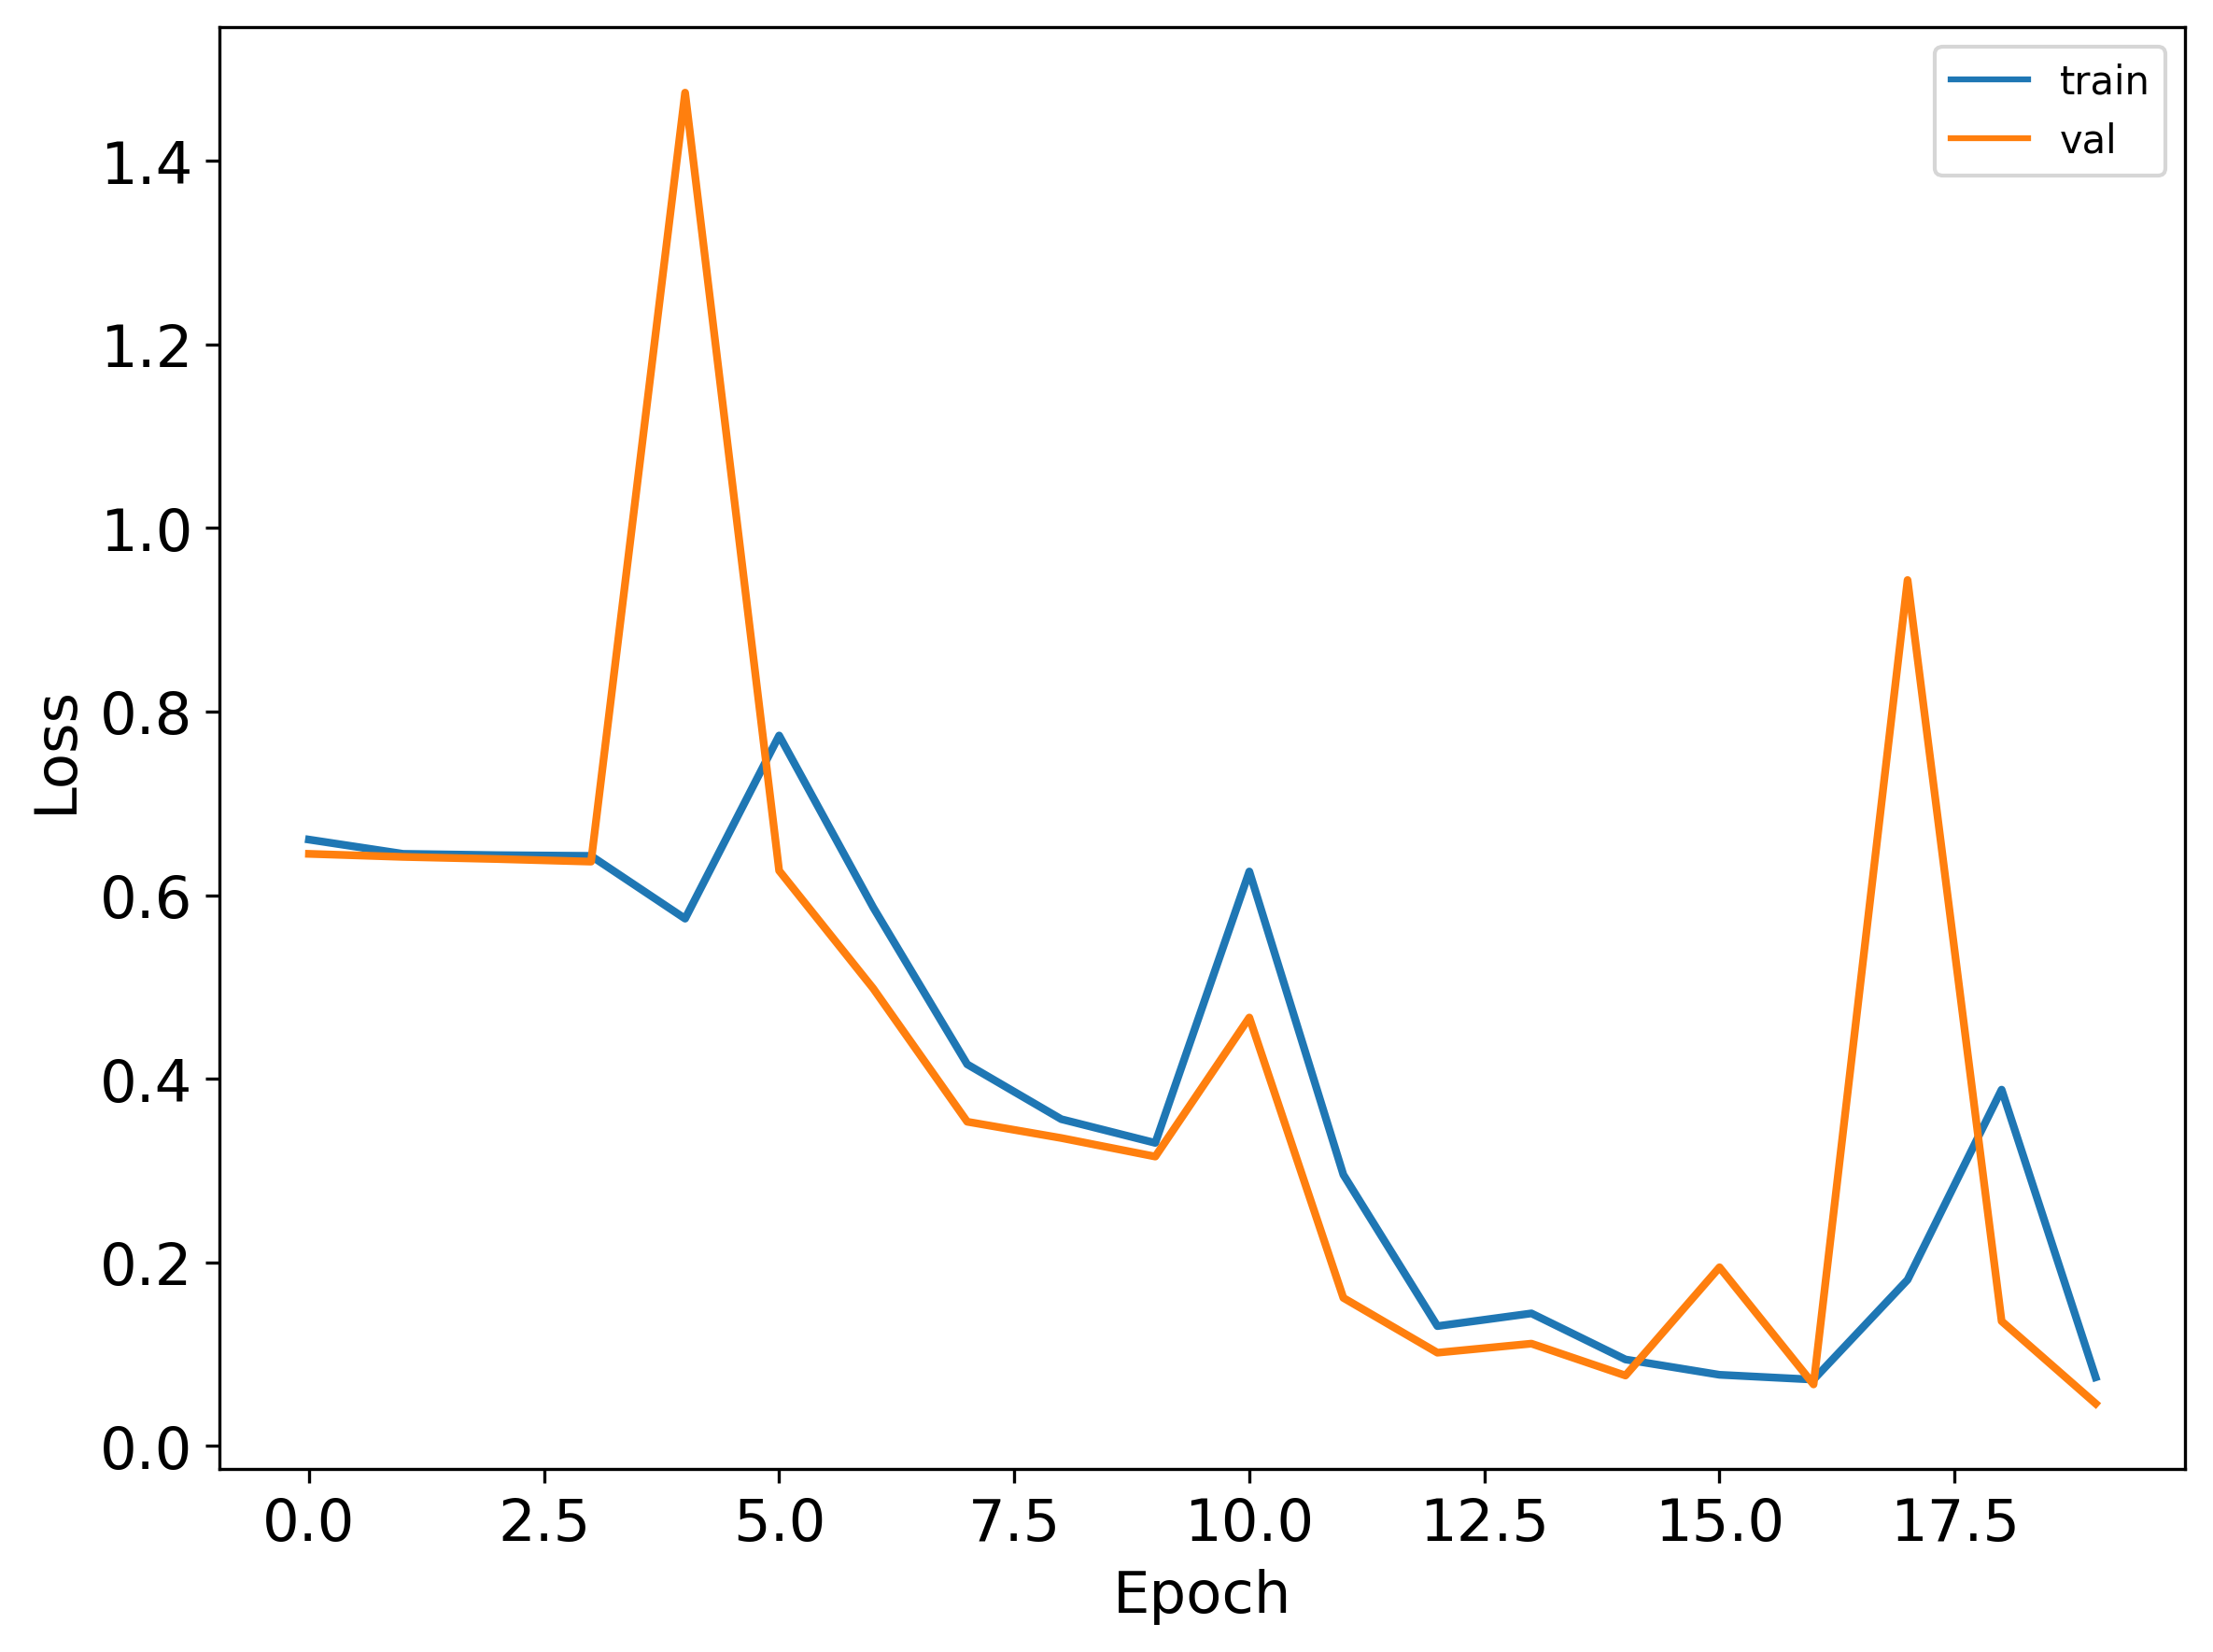

In [23]:
# create loss curves
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=ax, label="train")
sns.lineplot(x=range(len(val_loss)), y=val_loss, ax=ax, label="val")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

# increase font
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

# increase line width
for line in ax.lines:
    line.set_linewidth(2)

plt.tight_layout()
fig.savefig(f"figs/loss_e{EPOCHS}_bs{BATCH_SIZE}_lr{LR}_d{DROPOUT}_k{K}.png")

In [ ]:
# get accuracy
model.cpu()
model.eval()
correct = 0
total = 0

# subset
data_sample = data.sample(1000)

for i in tqdm(range(len(data_sample))):
    sequence = data.iloc[i]["sequence"]
    label = data.iloc[i]["label"]
    pred = model.predict(sequence)
    if pred == label:
        correct += 1
    total += 1

print(f"Accuracy: {correct / total * 100}%")

In [ ]:
# assign prediction to each sequence in the data
data_sample["prediction"] = data_sample["sequence"].apply(lambda x: model.predict(x))

# get confusion matrix
confusion_matrix = confusion_matrix(data_sample["label"], data_sample["prediction"])

# get F1 score
f1 = f1_score(data_sample["label"], data_sample["prediction"], average="macro")

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(confusion_matrix, annot=True, ax=ax, cmap="Blues", fmt="g")

ax.set_xlabel("Predicted")
ax.set_ylabel("True")

# increase font
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.tight_layout()

fig.savefig(f"figs/cm_e{EPOCHS}_bs{BATCH_SIZE}_lr{LR}_d{DROPOUT}_k{K}.png")